# Analyse adaptive CPG output

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import parameters 
import device 
import network
import plotting
import numpy as np

/home/asude/.local/lib/python3.8/site-packages/samna
finished bindings


In [2]:
# open DYNAP-SE1 board to get Dynapse1Model
dynapse = device.DynapseDevice(sender_port=12328, receiver_port=12329)
model = dynapse.model

[0]:  Bus 3 Device 53 Dynapse1DevKit serial_number 00000027
[1]:  Bus 1 Device 24 Dynapse1DevKit serial_number 00000032
[2]:  Bus 1 Device 27 Dynapse1DevKit serial_number 00000007
[3]:  Bus 1 Device 31 Dynapse1DevKit serial_number 00000020
[4]:  Bus 1 Device 25 Dynapse1DevKit serial_number 00000033
Sender port: tcp://0.0.0.0:12328
Receiver port: tcp://0.0.0.0:12329
Opened device name: my_dynapse1
SamnaNode ID: 1
PythonNode ID: 2


In [3]:
chip = 2
core_e1 = 0
core_e2 = 1
core_i = 2

duration = 2

neuron_ids_E1 = np.arange(11,19)
neuron_ids_E2 = neuron_ids_E1 + neuron_ids_E1.size
neuron_ids_I1 = [3]
neuron_ids_I2 =[4]

# init a network generator
net = network.DynapseNetworkGenerator()

neurons_E1 = net.get_neurons(chip, core_e1, neuron_ids_E1)
neurons_I1 = net.get_neurons(chip, core_i, neuron_ids_I1)
neurons_E2 = net.get_neurons(chip, core_e2, neuron_ids_E2)
neurons_I2 = net.get_neurons(chip, core_i, neuron_ids_I2)

net.add_connections_all_to_all(neurons_E1, neurons_E1, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E1, neurons_I1, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I1, neurons_E1, network.SYNAPSE_GABA_B, weight=8)

net.add_connections_all_to_all(neurons_E2, neurons_E2, network.SYNAPSE_AMPA)
net.add_connections_all_to_all(neurons_E2, neurons_I2, network.SYNAPSE_AMPA, weight=4)
net.add_connections_all_to_all(neurons_I2, neurons_E2, network.SYNAPSE_GABA_B, weight=8)

# coupling
net.add_connections_all_to_all(neurons_I1, neurons_I2, network.SYNAPSE_GABA_B)
net.add_connections_all_to_all(neurons_I2, neurons_I1, network.SYNAPSE_GABA_B)

dynapse.monitor_neuron_network(neurons_E1, neurons_E2, neurons_I1, neurons_I2)

model.apply_configuration(net.get_config())

Checking if the given network is valid to be deployed on DYNAP-SE1 chips...
Validation complete: the network is good to go!
Converted the validated network to a Dynapse1 configuration!


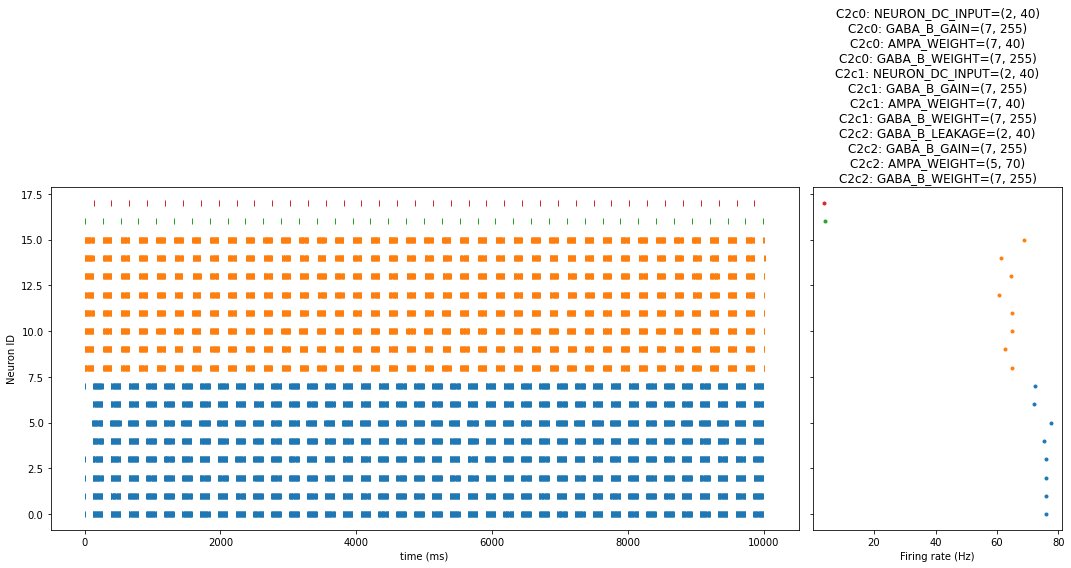

In [4]:
# set params
parameters.set_all_default_params(model)

# Core e1 parameters
parameters.set_param(model, parameters.AMPA_WEIGHT, (7,40), chip, core_e1)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_e1)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_e1)

# core e2 parameters 
parameters.set_param(model, parameters.AMPA_WEIGHT, (7,40), chip, core_e2)
parameters.set_param(model, parameters.NEURON_DC_INPUT, (2,40), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_e2)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_e2)

# Core i parameters
parameters.set_param(model, parameters.AMPA_WEIGHT, (5,70), chip, core_i)
parameters.set_param(model, parameters.GABA_B_WEIGHT, (7,255), chip, core_i)
parameters.set_param(model, parameters.GABA_B_LEAKAGE, (2,40), chip, core_i)
parameters.set_param(model, parameters.GABA_B_GAIN, (7,255), chip, core_i)

dynapse.start_graph()
spikes = dynapse.run_simulation(10)

# plotting.plot_spikes(dynapse, spikes)
plotting.plot_spikes_and_frequencies(dynapse, spikes, figsize=(15,8))


In [5]:
I1_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[2])
I2_spikes = plotting.extract_spikes_group(plotting.convert_spikes_to_array(spikes), dynapse.monitored_neuron_groups[3])
T1 = np.mean(np.diff(I1_spikes[:,0]))
T2 = np.mean(np.diff(I2_spikes[:,0]))
print(f'E1 firing rate: {1000/T1:.4f} Hz')
print(f'E2 firing rate: {1000/T2:.4f} Hz')
print(f'phase diff = {np.mean(I1_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]-I2_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]) / (T1+T2)*2 * 360} deg')

E1 firing rate: 3.8049 Hz
E2 firing rate: 3.8054 Hz
phase diff = -178.6230722077205 deg


In [17]:
lol = I1_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]-I2_spikes[:min(I1_spikes.shape[0],I2_spikes.shape[0]),0]
print(lol)
print(T1)

[-131 -130 -131 -130 -130 -130 -130 -130 -131 -130 -130 -130 -130 -131
 -130 -130 -130 -131 -130 -130 -131 -131 -131 -131 -130 -130 -130 -131
 -130 -130 -130 -130 -131 -131 -131 -131 -131 -130]
262.8157894736842


In [21]:
plotting.plot_interspike_intervals_hist(spikes, neuron_ids_I1, 10, figsize=(15,8))

AttributeError: module 'plotting' has no attribute 'plot_interspike_intervals_hist'

In [ ]:
dynapse.stop_graph()